In [16]:
# Define color codes to be used later in code 
class Color:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency

# Load the dataset
df_marketing_campaign = pd.read_csv('marketing_campaign.csv', sep='\t')
df_marketing_campaign.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Removing infrequent categories from 'Marital_Status'
df_marketing_campaign = df_marketing_campaign[~df_marketing_campaign.isin(['Alone', 'Absurd', 'YOLO'])]

# Create two samples for testing
data_1 = df_marketing_campaign.sample(frac=0.5)
data_2 = df_marketing_campaign.sample(frac=0.5)


In [27]:
# Kolmogorov-Smirnov Test
numeric_cols = ['Income', 'Recency', 'MntWines', 'MntFruits',
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# Significance level
p_value = 0.05
rejected = 0

for col in numeric_cols:
    test = stats.ks_2samp(data_1[col], data_2[col])
    print(col, test)
    if test[1] < p_value:
        rejected += 1
        print(Color.HEADER + "Column rejected:", col + Color.ENDC)

if rejected > 0:
    print(Color.FAIL + "Drift detected in numeric columns"+ Color.ENDC)
else:
    print(Color.OKGREEN + "No drift detected in numeric columns" + Color.ENDC)

print(Color.WARNING + "We rejected", rejected, "columns in total out of {} columns".format(len(numeric_cols))+ Color.ENDC)


Income KstestResult(statistic=nan, pvalue=nan, statistic_location=nan, statistic_sign=nan)
Recency KstestResult(statistic=0.02857142857142857, pvalue=0.7507688831864645, statistic_location=42, statistic_sign=-1)
MntWines KstestResult(statistic=0.016964285714285713, pvalue=0.9970680991992215, statistic_location=415, statistic_sign=-1)
MntFruits KstestResult(statistic=0.03214285714285714, pvalue=0.6095096717443, statistic_location=0, statistic_sign=-1)
MntMeatProducts KstestResult(statistic=0.030357142857142857, pvalue=0.6806946185920665, statistic_location=78, statistic_sign=-1)
MntFishProducts KstestResult(statistic=0.029464285714285714, pvalue=0.716045150544967, statistic_location=6, statistic_sign=-1)
MntSweetProducts KstestResult(statistic=0.020535714285714286, pvalue=0.9723293165727622, statistic_location=7, statistic_sign=1)
MntGoldProds KstestResult(statistic=0.03660714285714286, pvalue=0.4410874867221304, statistic_location=16, statistic_sign=-1)
NumDealsPurchases KstestResult(s

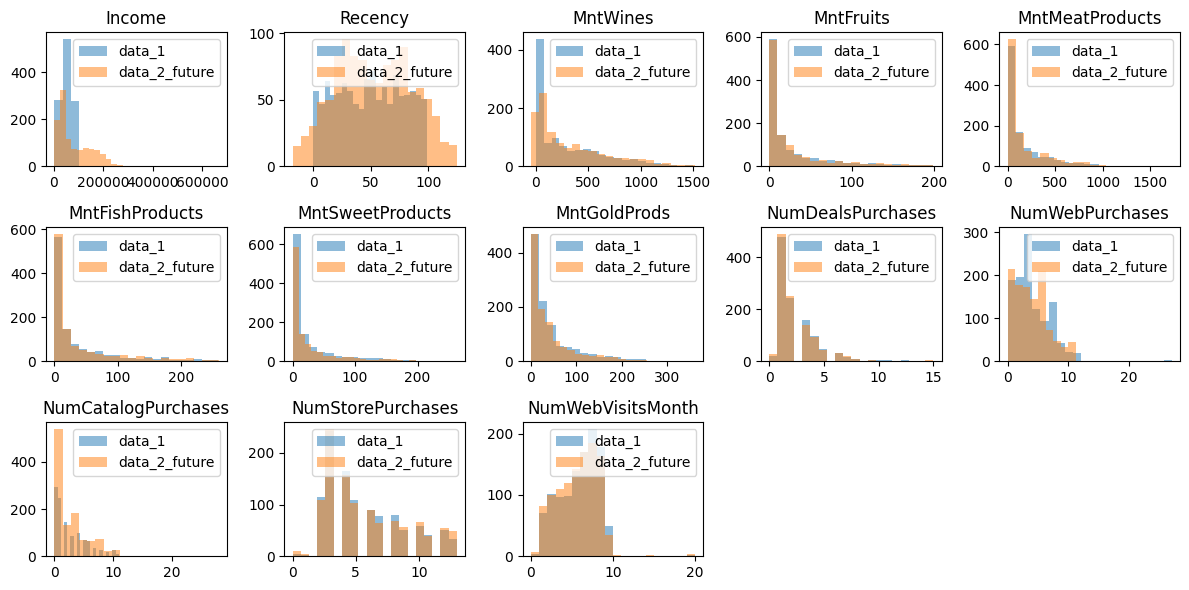

In [14]:
# Function to create significant drift in income
def create_significant_drift(v):
    rand = random.uniform(0, 1)
    if rand < 0.5:  # 50% chance to increase
        return v * random.uniform(2.0, 3.0)  # Increase income by 100-200%
    else:  # 50% chance to decrease
        return v * random.uniform(0.5, 0.7)  # Decrease income by 30-50%

# Function to handle future marital status changes
def future_marital_status(v):
    if v == "Married":
        return v
    else:
        coin_toss = random.uniform(0, 1)
        if coin_toss > 0.15:
            return v
        return 'Married'

# Create a future dataset with modifications
data_2_future = data_2.copy()

# Apply significant drift to income
data_2_future['Income'] = data_2_future['Income'].apply(create_significant_drift)

# Increase variability in numeric columns significantly
data_2_future['Recency'] = data_2_future['Recency'] + np.random.randint(-20, 30, size=len(data_2_future))
data_2_future['MntWines'] = data_2_future['MntWines'] + np.random.randint(-50, 100, size=len(data_2_future))

# Modify marital status to increase "Married" population
data_2_future['Marital_Status'] = data_2_future['Marital_Status'].apply(future_marital_status)


# Ensure all columns are numeric for the K-S test
numeric_cols = ['Income', 'Recency', 'MntWines', 'MntFruits',
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# Convert columns to numeric (if needed)
for col in numeric_cols:
    data_1[col] = pd.to_numeric(data_1[col], errors='coerce')
    data_2_future[col] = pd.to_numeric(data_2_future[col], errors='coerce')

# Visualize changes in distributions
plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols):
    plt.subplot(3, 5, i + 1)
    plt.hist(data_1[col], alpha=0.5, label='data_1', bins=20)
    plt.hist(data_2_future[col], alpha=0.5, label='data_2_future', bins=20)
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()


In [28]:
# Kolmogorov-Smirnov Test on future data
p_value = 0.05
rejected = 0

for col in numeric_cols:
    print(f"Testing column: {col}")  # Debugging output
    print("Data 1:", data_1[col].dropna().values)  # Debugging output
    print("Data 2 Future:", data_2_future[col].dropna().values)  # Debugging output
    
    test = stats.ks_2samp(data_1[col].dropna(), data_2_future[col].dropna())  # Drop NaN values
    print(col, test)
    if test[1] < p_value:
        rejected += 1
        print(Color.HEADER + "Column rejected:" , col + Color.ENDC)

if rejected > 0:
    print(Color.FAIL + "Drift detected in future numeric columns" + Color.ENDC)
else:
    print(Color.OKGREEN + "No drift detected in future numeric columns" + Color.ENDC)

print(Color.WARNING + "We rejected", rejected, "columns in total out of {} columns".format(len(numeric_cols))+ Color.ENDC)

Testing column: Income
Data 1: [72258. 83664. 39665. ... 36065. 56551. 19346.]
Data 2 Future: [156971.26770588 167893.04402598  31710.29529378 ...  91480.73714134
  32956.34388435  27397.72503656]
Income KstestResult(statistic=0.3525421878805503, pvalue=1.2488740206045785e-61, statistic_location=90300.0, statistic_sign=1)
Column rejected: Income
Testing column: Recency
Data 1: [28 57 97 ... 54 48 26]
Data 2 Future: [ 50  93  17 ... 110  79  36]
Recency KstestResult(statistic=0.08660714285714285, pvalue=0.00044630136140138145, statistic_location=96, statistic_sign=1)
Column rejected: Recency
Testing column: MntWines
Data 1: [522 866 127 ...  18  67   2]
Data 2 Future: [520 248 507 ...  18 461 106]
MntWines KstestResult(statistic=0.1392857142857143, pvalue=6.885452221100782e-10, statistic_location=43, statistic_sign=1)
Column rejected: MntWines
Testing column: MntFruits
Data 1: [ 0 21  1 ...  7  4  0]
Data 2 Future: [49 43 42 ...  3  0  3]
MntFruits KstestResult(statistic=0.0321428571428

In [20]:
# Chi-square Test for Categorical Data
def drift_chisquare(sample1, sample2):
    return chi2_contingency([sample1, sample2])[1]

categorical_cols = ['Education', 'Marital_Status']

# Print unique values in categorical columns
for col in categorical_cols:
    print(col, set(df_marketing_campaign[col].values))


Education {'Master', 'Basic', '2n Cycle', 'PhD', 'Graduation'}
Marital_Status {'Alone', 'Widow', 'Together', 'YOLO', 'Single', 'Absurd', 'Divorced', 'Married'}


In [29]:
rejected = 0

for col in categorical_cols:
    val = drift_chisquare(data_1[col].value_counts(), data_2[col].value_counts())
    print(col, val)
    if val < p_value:
        rejected += 1
        print(Color.HEADER + "Column rejected:", col + Color.ENDC)

if rejected > 0:
    print(Color.FAIL + "Drift detected in categorical columns" + Color.ENDC)
else:
    print(Color.OKGREEN + "No drift detected in categorical columns" + Color.ENDC)

print(Color.WARNING + "We rejected", rejected, "columns in total out of {} columns".format(len(categorical_cols)) + Color.ENDC)


Education 0.8647350408631458
Marital_Status 0.5447697503764561
No drift detected in categorical columns
We rejected 0 columns in total out of 2 columns


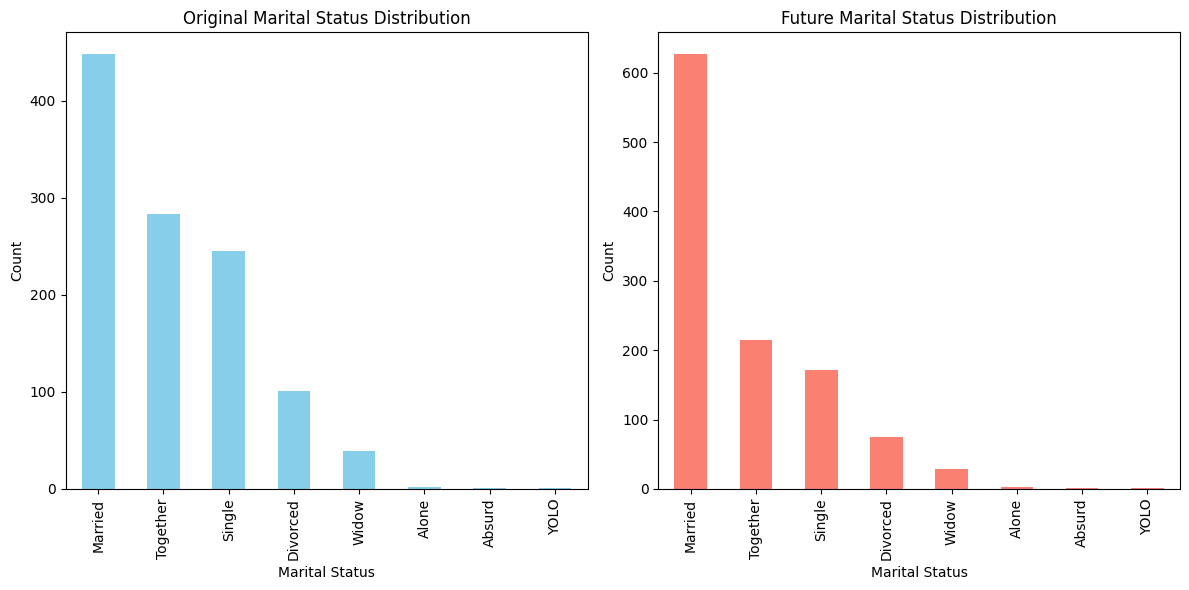

In [22]:
# Simulate an increase in the married population
def future_marital_status(v):
    if v == "Married":
        return v
    else:
        coin_toss = random.uniform(0, 1)
        if coin_toss > 0.15:
            return v
        return 'Married'

data_2_future['Marital_Status'] = data_2_future['Marital_Status'].apply(lambda v: future_marital_status(v))

# Visualize changes in marital status
plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
data_2['Marital_Status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Original Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Count')

# Future data
plt.subplot(1, 2, 2)
data_2_future['Marital_Status'].value_counts().plot(kind='bar', color='salmon')
plt.title('Future Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [30]:
rejected = 0

for col in categorical_cols:
    val = drift_chisquare(data_1[col].value_counts(), data_2_future[col].value_counts())
    print(col, val)
    if val < p_value:
        rejected += 1
        print(Color.HEADER + "Column rejected:" , col + Color.ENDC)

if rejected > 0:
    print(Color.FAIL + "Drift detected in future categorical columns" + Color.ENDC)
else:
    print(Color.OKGREEN + "No drift detected in future categorical columns" + Color.ENDC)

print(Color.WARNING + "We rejected", rejected, "columns in total out of {} columns".format(len(categorical_cols)) + Color.ENDC)


Education 0.8647350408631458
Marital_Status 3.377213822790367e-15
Column rejected: Marital_Status
Drift detected in future categorical columns
We rejected 1 columns in total out of 2 columns
